In [1]:
!pip install diffprivlib
import diffprivlib.models as dp
import psutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

     |████████████████████████████████| 81kB 3.2MB/s 
  Created wheel for diffprivlib: filename=diffprivlib-0.4.1-cp37-none-any.whl size=153526 sha256=105a642d353467fc24265c6d5931d28da935b7b223dbea873320dc09946ae24c
  Stored in directory: /root/.cache/pip/wheels/76/55/d3/be3c4635eecedcf48e196272b356c2b3bd11460962fc952e1b
Successfully built diffprivlib


In [2]:
start_time = time.time()
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/balance-scale/balance-scale.data'
column_names = ['Class Name', ' Left-Weight', ' Left-Distance', ' Right-Weight', 'Right-Distance']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=',', skipinitialspace=True)


In [3]:
dataset = raw_dataset.copy()

In [4]:
dataset = dataset.dropna()
dataset.head()

,Class Name,Left-Weight,Left-Distance,Right-Weight,Right-Distance
0,B,1,1,1,1
1,R,1,1,1,2
2,R,1,1,1,3
3,R,1,1,1,4
4,R,1,1,1,5


In [5]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)


In [6]:
X_train = train_dataset.copy()
X_test = test_dataset.copy()

y_train = X_train.pop('Class Name')
y_test = X_test.pop('Class Name')


In [7]:
from sklearn.linear_model import LogisticRegression as sk_LogisticRegression

logreg = Pipeline([
    ('scaler', Normalizer()), 
    ('clf', sk_LogisticRegression()) 
])

logreg.fit(X_train, y_train)

baseline = logreg.score(X_test, y_test)
print("Non-private baseline R2 score: %.2f" % baseline)


Non-private baseline R2 score: 0.92


In [8]:
from diffprivlib.models import LinearRegression
dp_logreg = Pipeline([
    ('scaler', Normalizer()), 
    ('clf', dp.LogisticRegression(epsilon=float("inf"), data_norm=2)) 
])

dp_logreg.fit(X_train, y_train)

baseline2 = dp_logreg.score(X_test, y_test)
print("private baseline R2 score: %.2f" % baseline2)


private baseline R2 score: 0.92


In [9]:
epsilons = np.logspace(-3, 2, 500)
accuracy = []
cpu_Overhead = []
mem_Overhead = []

for epsilon in epsilons:
    dp_logreg.set_params(clf__epsilon=epsilon).fit(X_train, y_train)
    
    cpu_Overhead.append(psutil.cpu_percent())
    psutil.virtual_memory()
    dict(psutil.virtual_memory()._asdict())
    mem_Overhead.append(psutil.virtual_memory().percent)
    
    accuracy.append(dp_logreg.score(X_test, y_test))

--- 8.332706928253174 seconds ---


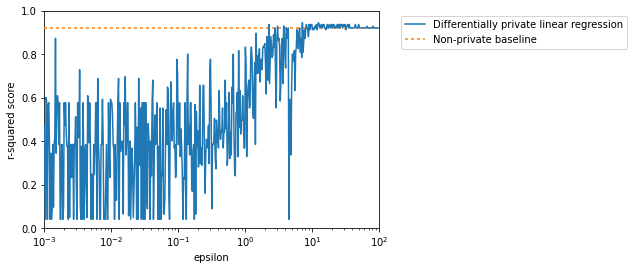

In [10]:
print("--- %s seconds ---" % (time.time() - start_time))
plt.semilogx(epsilons, accuracy, label="Differentially private linear regression", zorder=10)
plt.semilogx(epsilons, baseline * np.ones_like(epsilons), dashes=[2,2], label="Non-private baseline", zorder=5)
plt.xlabel("epsilon")
plt.ylabel("r-squared score")
plt.ylim(0, 1)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('balance.png')

In [11]:
print(sum((cpu_Overhead))/500)
print(sum((mem_Overhead))/500)

51.73280000000001
6.300200000000043


In [12]:
accuracy_final1 = []
for _ in " "*10: 
  dp_logreg.set_params(clf__epsilon=1).fit(X_train, y_train) 
  accuracy_final1.append(dp_logreg.score(X_test, y_test))


In [13]:
accuracy_final01 = []
for _ in " "*10: 
  dp_logreg.set_params(clf__epsilon=0.1).fit(X_train, y_train) 
  accuracy_final01.append(dp_logreg.score(X_test, y_test))

In [14]:
accuracy_final001 = []
for _ in " "*10: 
  dp_logreg.set_params(clf__epsilon=0.01).fit(X_train, y_train) 
  accuracy_final001.append(dp_logreg.score(X_test, y_test))

In [15]:
accuracy_final = []
accuracy_final1.remove(max(accuracy_final1))
accuracy_final1.remove(min(accuracy_final1))

accuracy_final01.remove(max(accuracy_final01))
accuracy_final01.remove(min(accuracy_final01))

accuracy_final001.remove(max(accuracy_final001))
accuracy_final001.remove(min(accuracy_final001))

accuracy_final.append(sum(accuracy_final1)/10)
accuracy_final.append(sum(accuracy_final01)/10)
accuracy_final.append(sum(accuracy_final001)/10)

In [16]:
accuracy_final

[0.5288, 0.3456, 0.2136]

In [17]:
accuracy_NP = []
for _ in " "*10: 
  logreg.set_params(clf__solver='lbfgs').fit(X_train, y_train) 
  accuracy_NP.append(logreg.score(X_test, y_test))

In [18]:
print(sum(accuracy_NP)/10)

0.9200000000000002
